In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data1 = pd.read_excel (r'C:\Users\callu\Dropbox\03ShOpen1mmGBon_29.38mK_BB3.21.xlsx')
data2 = pd.read_excel (r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\_C04P03ShClosed_44.66mK_BB3.20K.xlsx')

# Things to do
+ Completely change the idea of the identify regions method: test - make work for non-super
+ Investigate the y_offset problem -
+ Take a look at the raw data files
+ Write method to find regions which can work with partial data
+ Read in qdp files
    
# Done: 
+ (0) ~~Streamline class~~
~~(0) to identify regions (ohmic/ transition/ superconducting) : convert into method~~
~~(1) -Fix lists implimentation of findregions or revert to old-~~
4. (4) ~~Make a method that calculated R_stray : Do least squares from x=0~~
2. (2) ~~-make animation of threshold changing-~~
5. (5) ~~Made another calc_superconducting so that it can be called before anything else~~
2. (2) ~~Maybe use the supercondcting region to find the offset~~
3. (3) ~~Make the power read-out more robust - use least squares on the gradients. (did it with 0 grad points, average them)~~

In [34]:
data4 = pd.read_excel (r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\17D.xls')

In [274]:
class TES(object):
    '''
    
    Methods:
    self.plotPV() - plots PV graph
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    self.plotRegions(raw=1) - set raw to false to plot analysed IV regions
    
    #TODO - Store the temperatures in the object
    '''
    
    def __init__(self, rawIV, params = 0, R_stray = 0): 
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two coloums of the dataframe and saves 
        them as attributes. Dataframe can consist of more coloums but they are ignored. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be inlcuded as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attriutes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - whether the data shows signs of superconductivity
        y_offset (float) 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- experimental parameters
        gain (float) - calcuated from M_ratio and R_fb
        R_stray (float) - either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range
        '''
        
        # Drop NaNs in spreadsheet to prevent errors later 
        self.rawI = (rawIV.iloc[:,0].dropna()).values #Store as individual np.arrays for more readable code
        self.rawV = (rawIV.iloc[:,1].dropna()).values
        
        self.raw_grad = np.gradient(self.rawV, self.rawI)#Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend
        
        #iniditalise these values with the methods
        self.calc_y_offset()
        #self.calc_offsets()
        
        
        # All needed to calculate adjusted I and V etc. If params are included in initialisation, then they are
        # used. Otherwise defualts are used.
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except:
                print("Error: Parameters not correct")
                return
        else:
            print("Using defualt paramters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        # R_stray can be calculated using the class method or manually set
        
        self.calc_I_TES() #I_TES must first be generated to find R_Stray
        
        if R_stray:
            self.R_stray = R_stray
        else:
            self.calc_R_stray()
            
        self.calc_V_bias()
        self.calc_R_TES()
        self.calc_P_TES()
        
        self.plotIV(False) # Doesn't plot, just saves self.rnn
        
    ############################calc_methods############################   
    
    def calc_y_offset_ohmic(self):
        '''
        Input: Threshold percentage (int)
        OutPut: D (float)
        '''
        if self.superconducting:
            self.identify_regions()
            C, D , xvals = self.fit_ohmic(self.rawI, self.rawV)
            self.y_offset = D
            
            #TODO find out why I did this
            self.rawXvals = xvals
        else:
            C, D = curve_fit(self.f, self.rawI, self.rawV)[0]
            self.y_offset = D
            self.ohmic_reg = [(0, len(self.rawI/2)),(len(self.rawI/2)+1, -1)]
            self.transition_reg = False
            self.super_reg = False
    
    def calc_y_offset(self):
        if self.superconducting:
            self.identify_regions()
            C, D , xvals = self.fit_super(self.rawI, self.rawV)
            self.y_offset = D
            
            
        else:
            C, D = curve_fit(self.f, self.rawI, self.rawV)[0]
            self.y_offset = D
            self.ohmic_reg = [(0, len(self.rawI/2)),(len(self.rawI/2)+1, -1)]
            self.transition_reg = False
            self.super_reg = False
        
    def calc_offsets(self):
        if self.superconducting:
            self.identify_regions()
            E, F, xvals = self.fit_ohmic(self.rawI, self.rawV)
            self.y_offset = F
            
            self.V_offset = [entry - F for entry in self.rawV]
            print('yoffset')
            print(F)
            plt.plot(self.rawI, self.V_offset)
            plt.plot(self.rawI, self.rawV)
            
            
            C, D , xvals = self.fit_super(self.rawI, self.V_offset)
            print('xoffset')
            print(C/D)
            
            self.x_offset = -C/D
            
            self.I_offset = [entry + self.x_offset for entry in self.rawI]
            
            plt.plot(self.I_offset, self.V_offset)
            plt.grid()
            plt.axvline(0)
            plt.axhline(0)
            plt.show()
        else:
            C, D = curve_fit(self.f, self.rawI, self.rawV)[0]
            self.y_offset = D
            self.x_offset = -C/D
            self.ohmic_reg = [(0, len(self.rawI/2)),(len(self.rawI/2)+1, -1)]
            self.transition_reg = False
            self.super_reg = False
        
        
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_tes (array) data from tweak(float), y_offset (float), gain (float).
        tweaks not yet used
        '''
        
        self.I_TES = [((entry) - self.y_offset) * (10**6) * self.gain for entry in self.V_offset]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generates V_bias data
        '''
        self.V_bias = [((self.rawI[i] - self.x_offset) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        self.P_TES = [self.I_TES[index] * self.V_bias[index] for index in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Test if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if max(grad) > 3*(grad_av) and abs(min(grad)) > 5*(grad_av):
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    def calc_R_stray(self, start = 0 , end = 0.0005, step = 0.0000001):
        '''
        Go through a range of R_strays and find the one which gives the least error when compared to the yaxis. 
        Then set this as self.rstray
        Inputs:
        start, end and step : (floats)
        used in np.arange function that searches for R_stray. So the precision of R_stray value will depend on these.
        threshold: (float)
        The margin around the axis which you want to consider for catching points. 
        '''
        #Initialise lists for storage of results
        resists = []
        scores = []

        for resist in np.arange(start, end, step):
            V_bias = []
            start , stop = self.super_reg[0]
            
            for index in range(start, stop):
                        V_bias.append((self.I_offset[index] * self.R_shunt) - (self.I_TES[index]*(self.R_shunt + resist)))
            score = 0
            for entry in V_bias:
                    score += abs(entry)**2

            # Scores are errors, make a list so we can find the resistance that has lowest error
            scores.append(score)
            resists.append(resist)
        
        plt.plot(resists, scores)
        self.R_stray = resists[np.argmin(scores)]
    
    ############################utility methods############################   
    
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
        
    def identify_regions(self):
        ''' Identifies the different regions of data (ohmic/transition/superconducting) and saves thier indices
        '''
        
        #Check if the data is superconducting, does not proceed if not.
        if not self.superconducting:
            print("Error: TES is not superconducting")
            return 1
        
        ohmic_reg = []
        trans_reg = []
        super_reg = []
        
        index = 0
        ohmic_grad = sum(self.raw_grad[:10])/10
        
        
        #Identify first ohmic region by when the gradient deviates from average of original 
        while True:
            if self.raw_grad[index] < ohmic_grad * 0.99:
                ohmic_reg.append((0, index - 1))
                break

            index += 1

        start = index
        #When the gradient becomes positive once again this indicates superconductivty 
        while True:
            if self.raw_grad[index] > ohmic_grad * 2:
                trans_reg.append((start, index-1))
                break
            index += 1

        start = index
        #When the gradient becomes negative again, second transition region
        while True:
            if self.raw_2grad[index] < min(self.raw_2grad)/10 and self.raw_grad[index] > 0:
                index+=1
                super_reg.append((start,index))
                break
            index += 1

        start = index + 1 
        # No longer trans when the gradient returns to the ohmic
        while True:
            if self.raw_grad[index] > ohmic_grad * 0.99:
                trans_reg.append((start, index))
                break
            index += 1
        
        # The rest of the indices are assumed to be ohmic again
        ohmic_reg.append((index + 1, len(self.raw_grad) - 1))
        
        # Save the reions as attributes in the object
        self.ohmic_reg = ohmic_reg
        self.trans_reg = trans_reg
        self.super_reg = super_reg
        
    def fit_ohmic(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        r1start, r1end = self.ohmic_reg[0]
        r2start, r2end = self.ohmic_reg[1]
        
        firstx = min(inputdataX)
        lastx = max(inputdataX)
        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:r1end]
        yvals2 = inputdataY[r2start:r2end]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdataX[r1start:r1end]
        xvals2 = inputdataX[r2start:r2end]
        lineDataX = np.append(xvals1, xvals2)

        #fit the sliced data to a line
        C, D = curve_fit(self.f, lineDataX, lineDataY)[0]

        return C , D , xvals
    
    def fit_super(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals. These are then used 
        to fit a straight line to the straight superconducting region.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        super_start, super_end = self.super_reg[0]
        firstx = inputdataX[super_start]
        lastx = inputdataX[super_end]
        xvals = np.linspace(firstx, lastx)
        
        #Slice the data in the frame and store in an array 
        yvals = inputdataY[super_start:super_end]
        xvals = inputdataX[super_start:super_end]
        print(xvals)
        print(yvals)
        
        #fit the sliced data to a line
        C, D = curve_fit(self.f, xvals, yvals)[0]

        return C , D , xvals
    
    def power_readout(self):
        p_grad = np.gradient(self.P_TES, self.V_bias)
        constants = []
        for i in range(len(p_grad)):
            if abs(p_grad[i]) < 0.1:
                constants.append(self.P_TES[i])

        return sum(constants)/len(constants)
    
    ###############Plotting Methods###################
    def plotIV(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        C, D , Axvals = self.fit_ohmic(self.V_bias, self.I_TES)
        self.rnn = 1/C
        if plot:
            fig, ax = plt.subplots()
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line')
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV')
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            
    def plotPR(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.R_TES, self.P_TES, label='TES PR')
        plt.title("Power vs Resistance Curve")
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout()
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.axvline(self.rnn, color='r',label='Rnn: ' + str(round(self.rnn,5)))
        plt.legend()
    
    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV')
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout()
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        
    def plotRegions(self, raw = True):
        '''
        Currently only works for supercondicting
        '''
        fig, ax = plt.subplots()
        if raw:
            ohmic_data = np.append(self.rawI[:(self.ohmic_reg[0][1])], self.rawI[self.ohmic_reg[1][0]:])
            ohmic_V = np.append(self.rawV[:(self.ohmic_reg[0][1])],self.rawV[self.ohmic_reg[1][0]:])

            trans_data = np.append(self.rawI[self.trans_reg[0][0]: self.trans_reg[0][1]], self.rawI[self.trans_reg[1][0]:self.trans_reg[1][1]])
            trans_V = np.append(self.rawV[self.trans_reg[0][0]: self.trans_reg[0][1]], self.rawV[self.trans_reg[1][0]:self.trans_reg[1][1]])

            super_data = self.rawI[self.super_reg[0][0]:self.super_reg[0][1]]
            super_V = self.rawV[self.super_reg[0][0]:self.super_reg[0][1]]
            
            plt.scatter(ohmic_data, ohmic_V, label='Ohmic')
            plt.scatter(trans_data, trans_V, label='Transition')
            plt.scatter(super_data, super_V, label='Superconducting')
            ax.set_xlabel("I Bias (mA)")
            ax.set_ylabel("V Feedback (V)")
            plt.title("Raw IV Curve")
            plt.grid()
            plt.legend()
            #plt.show()
        else:
            ohmic_data = np.append(self.I_TES[:(self.ohmic_reg[0][1])], self.I_TES[self.ohmic_reg[1][0]:])
            ohmic_V = np.append(self.V_bias[:(self.ohmic_reg[0][1])],self.V_bias[self.ohmic_reg[1][0]:])

            trans_data = np.append(self.I_TES[self.trans_reg[0][0]: self.trans_reg[0][1]], self.I_TES[self.trans_reg[1][0]:self.trans_reg[1][1]])
            trans_V = np.append(self.V_bias[self.trans_reg[0][0]: self.trans_reg[0][1]], self.V_bias[self.trans_reg[1][0]:self.trans_reg[1][1]])

            super_data = self.I_TES[self.super_reg[0][0]:self.super_reg[0][1]]
            super_V = self.V_bias[self.super_reg[0][0]:self.super_reg[0][1]]
            
            plt.scatter(ohmic_V, ohmic_data, label='Ohmic')
            plt.scatter(trans_V, trans_data, label='Transition')
            plt.scatter(super_V, super_data, label='Superconducting')
            
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            plt.grid()
            plt.legend()
            plt.show()
        
        
        
    ###############Methods TODO###################
    def smooth_IV(): #Remove qunatum jumps?
        #TODO
        ''' Maybe a function to smooth noisy data before we find the 
        y offset. 
        Inputs: rawIV (or just use self?)
        Outputs: stores smoothRawIV in self
        '''
        pass

In [275]:
params = [3002.9, 18.93333, 0.001115]
RT = TES(data4, params)

[-4.992797  0.        4.992797 10.003816]
[-0.614594  -0.376178  -0.136908   0.0867353]


AttributeError: 'TES' object has no attribute 'V_offset'

0.00023
0.00023


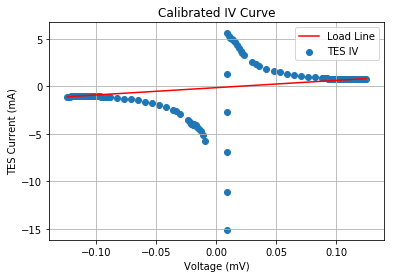

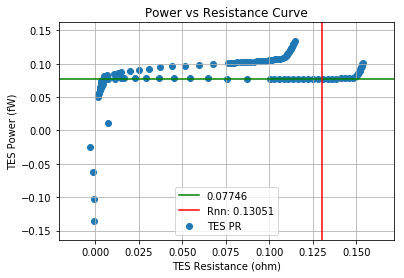

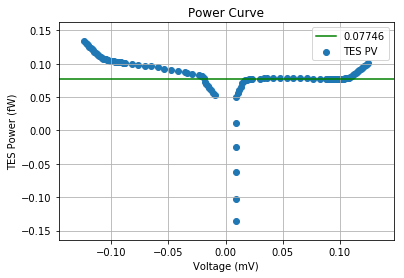

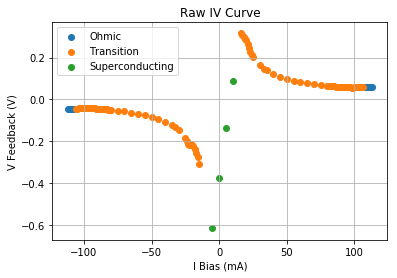

In [273]:
print(RT.R_stray)
RT.R_stray = 0.00023
print(RT.R_stray)
RT.calc_V_bias()
RT.calc_I_TES()
RT.calc_R_TES()
RT.calc_P_TES()
RT.plotIV()
RT.plotPR()
RT.plotPV()
RT.plotRegions(1)

[-4.992797  0.        4.992797 10.003816]
[-0.614594  -0.376178  -0.136908   0.0867353]


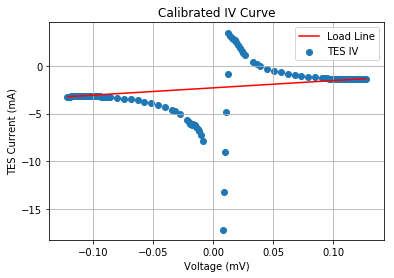

In [263]:
RT.calc_y_offset()
RT.calc_y_offset_ohmic() 

RT.calc_V_bias()
RT.calc_I_TES()
RT.calc_R_TES()
RT.calc_P_TES()
RT.plotIV()

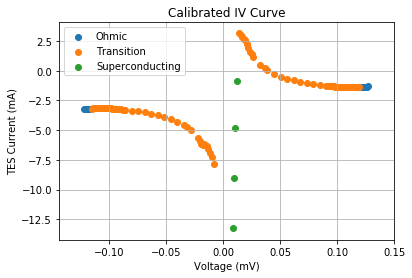

In [264]:
RT.plotRegions(0)
#plt.plot(xvals, RT.f(xvals, C , D))

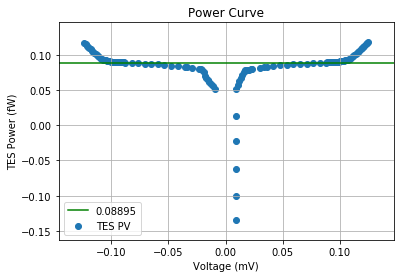

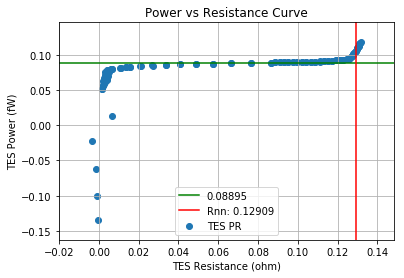

In [184]:
RT.plotPV()
RT.plotPR()

In [68]:
T1 = TES(data1)

[-2.04538716 -1.97919251 -1.91426959 -1.84782913 -1.78138867 -1.71526882
 -1.64871081 -1.58248409 -1.51606501 -1.48354477 -1.4499131  -1.4176066
 -1.38516117 -1.37190941 -1.35852941 -1.34554483 -1.33234651 -1.31899857
 -1.30590712 -1.29260193 -1.27923262 -1.26613048 -1.25285735 -1.23962697
 -1.22664238 -1.213412   -1.20040604 -1.18715429 -1.17393459 -1.16082176
 -1.14766619 -1.13451062 -1.12137642 -1.10804985 -1.09501183 -1.08202725
 -1.06879687 -1.05582084 -1.04275396 -1.02952892 -1.01631778 -1.00332144
 -0.99017441 -0.9771022  -0.96413044 -0.95110525 -0.93794967 -0.92514783
 -0.91223165 -0.89921287 -0.8874872  -0.87452292 -0.86754972 -0.86183543
 -0.85493169 -0.84905497 -0.84193108 -0.83621038 -0.82916237 -0.8232803
 -0.81644176 -0.81077236 -0.8038216  -0.79808594 -0.79111915 -0.7852296
 -0.77861227 -0.77277188 -0.76605409 -0.76030881 -0.75345317 -0.74795583
 -0.7412188  -0.7355633  -0.72895772 -0.72339733 -0.71659726 -0.71128159
 -0.70465037 -0.69908784 -0.69271524 -0.68734507 -0.68

-0.14540574000316606
[-2.04538716 -1.97919251 -1.91426959 -1.84782913 -1.78138867 -1.71526882
 -1.64871081 -1.58248409 -1.51606501 -1.48354477 -1.4499131  -1.4176066
 -1.38516117 -1.37190941 -1.35852941 -1.34554483 -1.33234651 -1.31899857
 -1.30590712 -1.29260193 -1.27923262 -1.26613048 -1.25285735 -1.23962697
 -1.22664238 -1.213412   -1.20040604 -1.18715429 -1.17393459 -1.16082176
 -1.14766619 -1.13451062 -1.12137642 -1.10804985 -1.09501183 -1.08202725
 -1.06879687 -1.05582084 -1.04275396 -1.02952892 -1.01631778 -1.00332144
 -0.99017441 -0.9771022  -0.96413044 -0.95110525 -0.93794967 -0.92514783
 -0.91223165 -0.89921287 -0.8874872  -0.87452292 -0.86754972 -0.86183543
 -0.85493169 -0.84905497 -0.84193108 -0.83621038 -0.82916237 -0.8232803
 -0.81644176 -0.81077236 -0.8038216  -0.79808594 -0.79111915 -0.7852296
 -0.77861227 -0.77277188 -0.76605409 -0.76030881 -0.75345317 -0.74795583
 -0.7412188  -0.7355633  -0.72895772 -0.72339733 -0.71659726 -0.71128159
 -0.70465037 -0.69908784 -0.69271

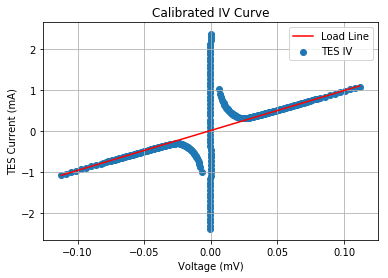

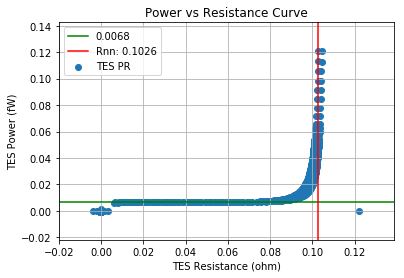

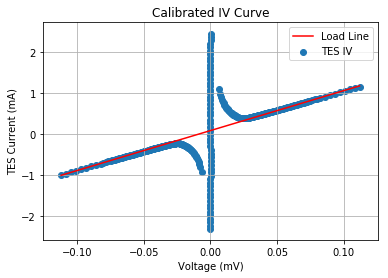

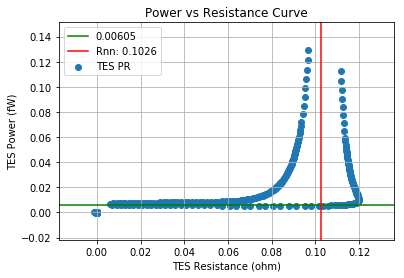

In [71]:
print(T1.y_offset)
T1.calc_y_offset()
T1.calc_V_bias()
T1.calc_I_TES()
T1.calc_R_TES()
T1.calc_P_TES()

T1.plotIV()
T1.plotPR()

T1.calc_y_offset_ohmic()
print(T1.y_offset)
T1.calc_V_bias()
T1.calc_I_TES()
T1.calc_R_TES()
T1.calc_P_TES()

T1.plotIV()
T1.plotPR()

In [1]:
T2 = TES(data2)

NameError: name 'TES' is not defined